<a href="https://colab.research.google.com/github/Itziar23/prueba/blob/master/principal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import sys
import os
from google.colab import drive
drive.mount('/content/gdrive')
ruta='gdrive/My Drive/dataset/CAMUS/'

Mounted at /content/gdrive


In [8]:
PROJECT_ROOT_DIR = "/content/gdrive/MyDrive/Colab Notebooks/"
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

In [9]:
pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.0 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os

%matplotlib inline

In [11]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [12]:
print(os.getcwd())

/content


In [13]:
import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/architectures')
from laddernet import LadderNet
from unet import UNet
from resunet import ResUNet

In [14]:
import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/metrics')
from multiclass_dice import multiclass_dice

In [15]:
import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/metrics')
from iou import iou

In [16]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 7
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [17]:
train_path = ruta + "training/patient0001/"

In [18]:
def mhd_to_array(path):
    """
    Read an *.mhd file stored in path and return it as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(path, sitk.sitkFloat32))

In [19]:
image = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient0001_4CH_ED.mhd", sitk.sitkFloat32))
mask = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient0001_4CH_ED_gt.mhd", sitk.sitkFloat32))

In [20]:
np.shape(image)

(1, 778, 549)

In [21]:
np.shape(mask)

(1, 778, 549)

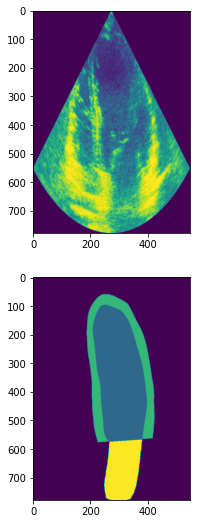

In [22]:
fig, ax = plt.subplots(2)
ax[0].imshow(image[0]) # End Diastolic frame
ax[1].imshow(mask[0]) # End Diastolic mask
plt.show()

In [23]:
image = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient0001_4CH_ES.mhd", sitk.sitkFloat32))
mask = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient0001_4CH_ES_gt.mhd", sitk.sitkFloat32))

In [24]:
np.shape(image)

(1, 778, 549)

In [25]:
np.shape(mask)

(1, 778, 549)

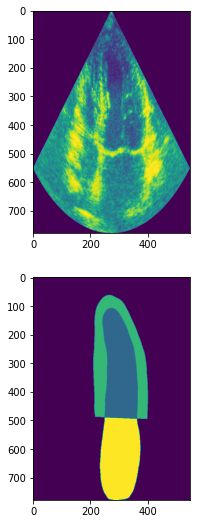

In [26]:
fig, ax = plt.subplots(2)
ax[0].imshow(image[0]) # End Diastolic frame
ax[1].imshow(mask[0]) # End Diastolic mask
plt.show()

In [27]:
# Standard
import os
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt
# Utils
import h5py
# Deep Learning
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [28]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)

In [29]:
f = h5py.File("gdrive/My Drive/dataset/image_dataset.hdf5", "r")

In [30]:
train_frames = f["train_4ch_ed_frames"][:,:,:,:]
train_masks = f["train_4ch_ed_masks"][:,:,:,:]
test_frames = f["test_4ch_ed_frames"][:,:,:,:]
test_masks = f["test_4ch_ed_masks"][:,:,:,:]

In [31]:
train_frames, valid_frames, train_masks, valid_masks = train_test_split(train_frames, train_masks)

In [32]:
model_laddernet = LadderNet(input_size=(384, 384, 1), num_classes=4, filters=20)
model_unet = UNet(input_size=(384, 384, 1), depth=5, num_classes=4, filters=10, batch_norm=True)

In [27]:
model_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 384, 384, 10  100         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_40 (BatchN  (None, 384, 384, 10  40         ['conv2d_30[0][0]']              
 ormalization)                  )                                                           

In [28]:
model_laddernet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 20  200         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 384, 384, 20  3620        ['conv2d[0][0]',                 
                                )                                 'dropout[0][0]']            

In [29]:
model_laddernet.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice,iou, "accuracy"])

In [30]:
history_laddernet=model_laddernet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=150,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/150
 16/135 [==>...........................] - ETA: 1:05 - loss: 1.3937 - multiclass_dice: 0.1622 - iou: 0.0902 - accuracy: 0.6669

KeyboardInterrupt: ignored

In [ ]:
model_laddernet.save_weights("/content/gdrive/MyDrive/Colab Notebooks/models/ladder_4ch_ed.h5")

In [ ]:
df=pd.DataFrame(history_laddernet.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot_1")
plt.show()

In [ ]:
model_unet.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice,iou, "accuracy"])

In [ ]:

history_unet=model_unet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=150,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/10
135/135 [==============================] - 1352s 10s/step - loss: 0.9618 - multiclass_dice: 0.5521 - accuracy: 0.8702 - val_loss: 2.8722 - val_multiclass_dice: 0.2912 - val_accuracy: 0.7376 - lr: 0.0010
Epoch 2/10
135/135 [==============================] - 1330s 10s/step - loss: 0.7242 - multiclass_dice: 0.7322 - accuracy: 0.9458 - val_loss: 4.4335 - val_multiclass_dice: 0.1813 - val_accuracy: 0.2832 - lr: 0.0010
Epoch 3/10
135/135 [==============================] - ETA: 0s - loss: 0.5968 - multiclass_dice: 0.7615 - accuracy: 0.9558
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
135/135 [==============================] - 1321s 10s/step - loss: 0.5968 - multiclass_dice: 0.7615 - accuracy: 0.9558 - val_loss: 1.6089 - val_multiclass_dice: 0.2838 - val_accuracy: 0.5210 - lr: 0.0010
Epoch 4/10
135/135 [==============================] - 1310s 10s/step - loss: 0.5000 - multiclass_dice: 0.8310 - accuracy: 0.9687 - val_loss: 0.5209 - val_multiclass_dice:

In [ ]:
model_unet.save_weights("/content/gdrive/MyDrive/Colab Notebooks/models/unet_4ch_ed.h5")

In [ ]:
df=pd.DataFrame(history_unet.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot_1")
plt.show()

In [ ]:
import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/architectures')


from cnn import CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def CNN(input_size, num_classes):
   # Crear modelo secuencial
   model = Sequential()

   # Agregar capas convolucionales y de max pooling
   model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(384, 384, 1)))
   model.add(MaxPooling2D((2, 2)))
   model.add(Conv2D(64, (3, 3), activation='relu'))
   model.add(MaxPooling2D((2, 2)))
   model.add(Conv2D(128, (3, 3), activation='relu'))
   model.add(MaxPooling2D((2, 2)))

   # Aplanar la salida y agregar capas densas
   model.add(Flatten())
   model.add(Dense(64, activation='relu'))
   model.add(Dense(4, activation='softmax'))
    
   return model


In [ ]:
model_cnn= CNN(input_size=(384, 384, 1),num_classes=4)

In [ ]:
model_cnn.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, iou,"accuracy"])

In [ ]:
model_cnn.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=150,
                    callbacks=[earlystop, reduce_lr])

In [31]:
import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/architectures')

from acnn import ACNN

In [32]:
model_acnn= ACNN(input_size=(384, 384, 1),num_classes=4)

In [33]:
model_acnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 384, 384, 1)]     0         
                                                                 
 conv2d_53 (Conv2D)          (None, 384, 384, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 192, 192, 32)     0         
 2D)                                                             
                                                                 
 conv2d_54 (Conv2D)          (None, 192, 192, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 96, 96, 64)       0         
 2D)                                                             
                                                                 
 conv2d_55 (Conv2D)          (None, 96, 96, 128)       7385

In [34]:
model_acnn.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, iou,"accuracy"])

In [35]:
history_acnn=model_acnn.fit(x=train_frames,
                    y=train_masks,
                    validation_data=(valid_frames, valid_masks),
                    batch_size=5,
                    epochs=150,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/150
135/135 [==============================] - 18s 95ms/step - loss: 0.3684 - multiclass_dice: 0.0659 - iou: 0.0390 - accuracy: 0.8727 - val_loss: 0.2767 - val_multiclass_dice: 0.3587 - val_iou: 0.2209 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 2/150
135/135 [==============================] - 12s 86ms/step - loss: 0.2900 - multiclass_dice: 0.1983 - iou: 0.1209 - accuracy: 0.8763 - val_loss: 0.2382 - val_multiclass_dice: 0.2145 - val_iou: 0.1244 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 3/150
135/135 [==============================] - ETA: 0s - loss: 0.2762 - multiclass_dice: 0.3168 - iou: 0.1956 - accuracy: 0.8805
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
135/135 [==============================] - 12s 87ms/step - loss: 0.2762 - multiclass_dice: 0.3168 - iou: 0.1956 - accuracy: 0.8805 - val_loss: 0.2327 - val_multiclass_dice: 0.2935 - val_iou: 0.1734 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 4/150
135/135 [==============================] - 12s 8

In [36]:
loss_acnn_4 = model_acnn.evaluate(x=test_frames,y=test_masks)

29/29 [==============================] - 8s 185ms/step - loss: 0.0111 - multiclass_dice: 0.0532 - iou: 0.0434 - accuracy: 0.9959


In [37]:
print(history_acnn.history.keys())

dict_keys(['loss', 'multiclass_dice', 'iou', 'accuracy', 'val_loss', 'val_multiclass_dice', 'val_iou', 'val_accuracy', 'lr'])


Saving figure keras_learning_curves_plot_1


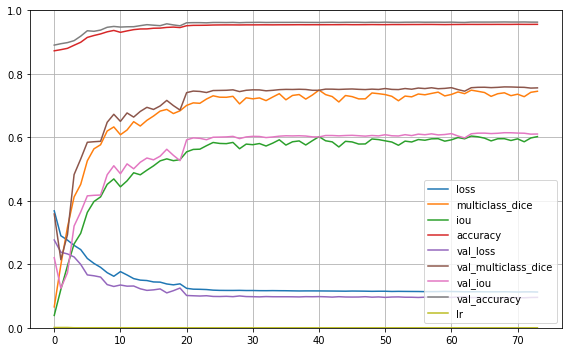

In [39]:
df=pd.DataFrame(history_acnn.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot_1")
plt.show()

In [40]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/file_name.csv')

In [41]:
model_acnn.save_weights("/content/gdrive/MyDrive/Colab Notebooks/models/acnn_4ch_ed.h5")

In [ ]:
loss_acnn_4 = model_acnn.evaluate(x=test_frames,
                    y=test_masks)

In [ ]:
print(type(model_acnn.history))

# MODELO RESUNET

In [33]:
model_resunet= ResUNet(input_shape=(384, 384, 1),num_classes=4)

In [35]:
model_resunet.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, iou, "accuracy"])

In [36]:
history_resunet=model_resunet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[valid_frames, valid_masks],
                    batch_size=3,
                    epochs=3,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/3
225/225 [==============================] - 213s 801ms/step - loss: 0.3136 - multiclass_dice: 0.1493 - iou: 0.0932 - accuracy: 0.8813 - val_loss: 0.2358 - val_multiclass_dice: 0.3671 - val_iou: 0.2372 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 2/3
225/225 [==============================] - 176s 781ms/step - loss: 0.2361 - multiclass_dice: 0.4123 - iou: 0.2760 - accuracy: 0.9013 - val_loss: 0.2143 - val_multiclass_dice: 0.4075 - val_iou: 0.2705 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 3/3
225/225 [==============================] - 172s 766ms/step - loss: 0.2139 - multiclass_dice: 0.4874 - iou: 0.3400 - accuracy: 0.9131 - val_loss: 0.1974 - val_multiclass_dice: 0.4986 - val_iou: 0.3536 - val_accuracy: 0.9237 - lr: 0.0010


In [37]:
model_resunet.save_weights("/content/gdrive/MyDrive/Colab Notebooks/models/resunet_4ch_ed.h5")


Saving figure keras_learning_curves_plot_1


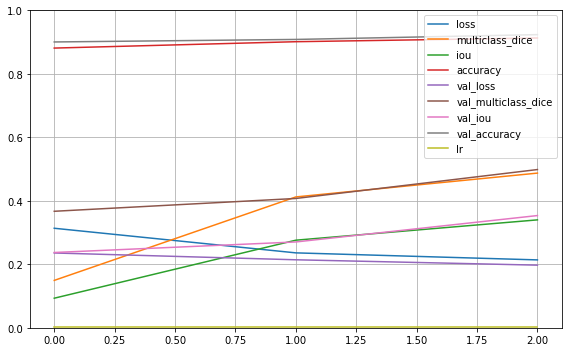

In [38]:
pd.DataFrame(history_resunet.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot_1")
plt.show()

# Aumento de datos

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
history_1 = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)
loss_test_1 = model.evaluate(test_set)

In [ ]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set_raw = tfds.load("cats_vs_dogs", split=test_split, as_supervised=True)
valid_set_raw = tfds.load("cats_vs_dogs", split=valid_split, as_supervised=True)
train_set_raw = tfds.load("cats_vs_dogs", split=train_split, as_supervised=True)

In [45]:
import imgaug.augmenters as iaa
import numpy as np
import cv2

# Carga la imagen y la máscara
img = train_frames[0]
mask = train_masks[0]
print(np.shape(img))
# Define el objeto de aumento de datos
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # Voltear la imagen horizontalmente
    iaa.Flipud(0.5), # Voltear la imagen verticalmente
    iaa.Affine(rotate=(-45, 45)), # Rotar la imagen
    iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)), # Agregar ruido gaussiano
    iaa.Multiply((0.5, 1.5)), # Ajustar el brillo de la imagen
    iaa.GammaContrast((0.5, 2.0)) # Ajustar el contraste de la imagen
], random_order=True)

# Generar 10 imágenes y máscaras aumentadas
images_aug = []
masks_aug = []
for _ in range(10):
    # Aplicar el aumento de datos a la imagen y la máscara
    image_aug, mask_aug = seq(image=img, segmentation_maps=mask)
    images_aug.append(image_aug)
    masks_aug.append(mask_aug)

# Mostrar una imagen y su máscara aumentada
cv2.imshow('Imagen aumentada', images_aug[0])
cv2.imshow('Máscara aumentada', masks_aug[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

(384, 384, 1)


ValueError: ignored